In [11]:
%reset -f
import ROOT

ROOT.gStyle.SetOptFit(0)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetGridColor(16)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)
ROOT.gStyle.SetLabelFont(42,'xy')
ROOT.gStyle.SetLabelSize(0.04,'xy')
ROOT.gStyle.SetTitleSize(0.05,'xy')
ROOT.gStyle.SetTitleOffset(0.95,'xy')
#ROOT.gStyle.SetPadRightMargin(0.05)
#ROOT.gStyle.SetPadLeftMargin(0.06)


fname = "data/lvl2_eppi0.inb.qa.root"
fname = "data/lvl2_eppi0.outb.qa.root"


dsid = 'inb' if 'inb' in fname else 'outb'


%run -i eppi0_columns.py

df = ROOT.RDataFrame("h22", fname)

df = define_eppi0_columns_using_proton(df)


%run -i eppi0_binning_scheme_v2.py

shards,df  = define_eppi0_bins(df, dsid)

In [12]:
hqx = df.Histo2D(("hqx",";x_{B};Q^{2} [GeV^{2}]",200,0,0.84,200,1.5,12), "xb","q2")

htts = []
hqxs = []
for iqx in range(int(df.Max("iqx").GetValue()+1)):
    qdf = df.Filter("iqx=="+str(iqx))
    htts.append((iqx, qdf.Histo1D(("htt","-t for qx bin "+str(iqx),100,0,2), "tt")))
    hqxs.append((iqx, qdf.Histo2D(("hqx","QX for qx bin "+str(iqx),100,0,0.84,100,0,12), "xb", "q2")))


0.6644150580902837 2.6350505465222143
0 (2.722499282269066, 0.2861790035776619) [0.64, 1.06]
1 (2.825506960714204, 0.4002291165430171) [0.6, 0.9400000000000001]
2 (4.383025505123796, 0.3949492767588621) [0.68, 1.1]
3 (4.1227103925977, 0.5145394717487675) [0.74, 1.1400000000000001]
4 (6.515253818709148, 0.5639799307792727) [0.98, 1.4000000000000001]
133318.0


Info in <TCanvas::Print>: pdf file pdf/eppi0.hqx.outb.pdf has been created


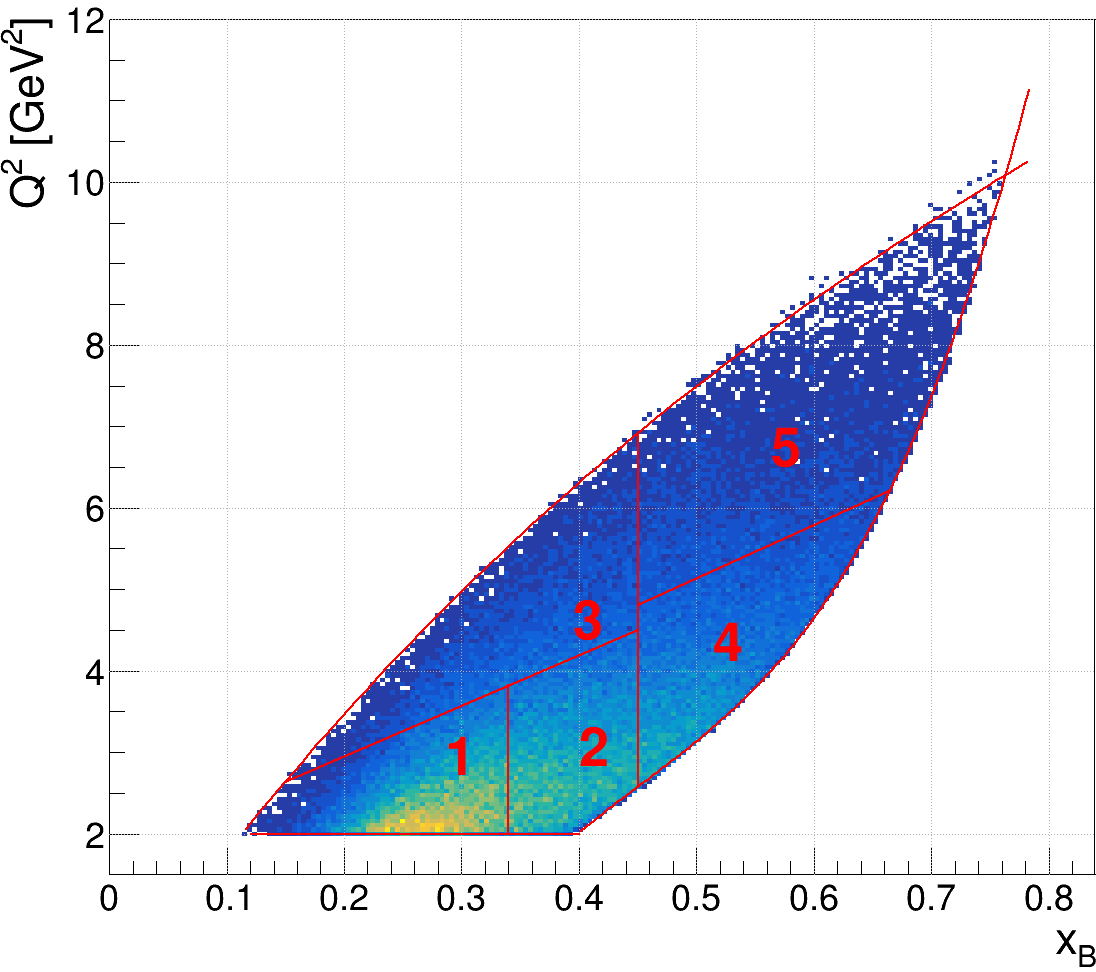

In [13]:
c1 = ROOT.TCanvas("c1","c1",1100,1000)
c1.SetMargin(0.1,0,0.1,0.02)
c1.Draw()

hqx.Draw("col")

gr0, gr1 = ROOT.TGraphErrors(), ROOT.TGraphErrors()
for ix in range(hqx.GetNbinsX()):
    hy = hqx.ProjectionY("hy",ix+1,ix+1)
    x,y0,y1 = hqx.GetXaxis().GetBinLowEdge(ix+1), hy.GetBinLowEdge(hy.FindFirstBinAbove(0)), hy.GetBinLowEdge(hy.FindLastBinAbove(0))
    if y0>2:
        if x>0.3:
            gr0.SetPoint(gr0.GetN(), x, y0)
        gr1.SetPoint(gr1.GetN(), x, y1)


f0 = ROOT.TF1("f0", "pol3",0,1)
f1 = ROOT.TF1("f1", "pol3",0,1)
gr0.Fit(f0,"Q")
gr1.Fit(f1,"Q")

f0.SetRange(0.4,0.785)
f1.SetRange(f1.GetX(2),0.785)

f0.Draw("same")
f1.Draw("same")

ll = ROOT.TLine()
ll.SetLineColor(2)
ll.SetLineWidth(2)

ll.DrawLine(0.12,2, 0.4,2)

#vertical lines
x0 = 0.34
ll.DrawLine(x0, 2, x0, 3.84)
x1 = 0.45
ll.DrawLine(x1, f0.Eval(x1), x1, f1.Eval(x1))

#horizontal lines
x0 = 0.15
y0 = f1.Eval(x0)
x1, y1 = 0.45,4.5
ll.DrawLine(x0, y0, x1, y1)


x4,y4 = 0.45, 4.8
y5 = 6.2
x5 = f0.GetX(y5)
print(x5,y0)
ll.DrawLine(x4, y4, x5, y5)


cols = [1,2,3,4,6,7]
for iqx,htt in htts:
    htt = htt.GetValue()
    htt.SetLineColor(cols.pop(0))
    nens = htt.Integral()/3
    itts = [1]
    for ib in range(htt.GetNbinsX()):
        if htt.Integral(itts[-1],ib+1)>nens:
            itts.append(ib+1)
    q2,xb = shards[(iqx,)]
    q2,xb = q2.GetValue(), xb.GetValue()
    print(iqx, (q2,xb), [htt.GetBinLowEdge(itt) for itt in itts[1:-1]])


lat = ROOT.TLatex()
lat.SetTextColor(2)
lat.SetTextSize(0.06)
iqx = 0
for tpl in shards:
    if len(tpl)==1:
        q2,xb = shards[tpl]
        q2 = q2.GetValue()
        xb = xb.GetValue()
        iqx += 1
        lat.DrawLatex(xb, q2, str(iqx))

print(hqx.Integral())

c1.Print(f"pdf/eppi0.hqx.{dsid}.pdf")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file pdf/eppi0.htts.outb.pdf has been created


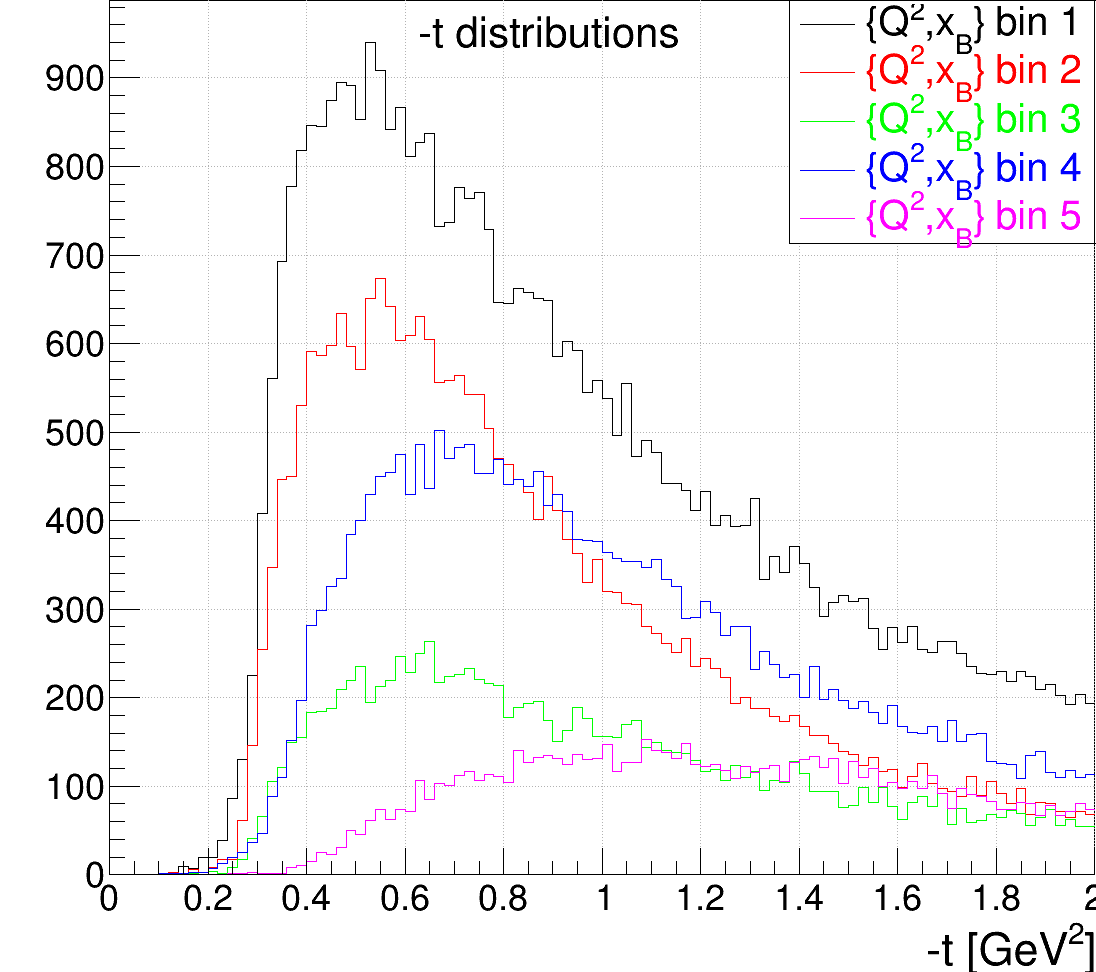

In [14]:
c1 = ROOT.TCanvas("c1","c1", 1100,1000)
c1.SetMargin(0.1,0.001,0.1,0.001)
c1.Draw()
    
leg = ROOT.TLegend(0.72,0.75,1,1)
hs = ROOT.THStack("hs","")
hs.SetTitle("-t distributions;-t [GeV^{2}]")
for iqx,htt in htts:
    htt = htt.GetValue()
    le = leg.AddEntry(htt, "{{Q^{{2}},x_{{B}}}} bin {}".format(iqx+1), "L")
    le.SetTextColor(htt.GetLineColor())
    hs.Add(htt)
hs.Draw("nostack")
leg.Draw()

c1.Print(f"pdf/eppi0.htts.{dsid}.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file pdf/eppi0.mgg.bin.fit.example.pdf has been created


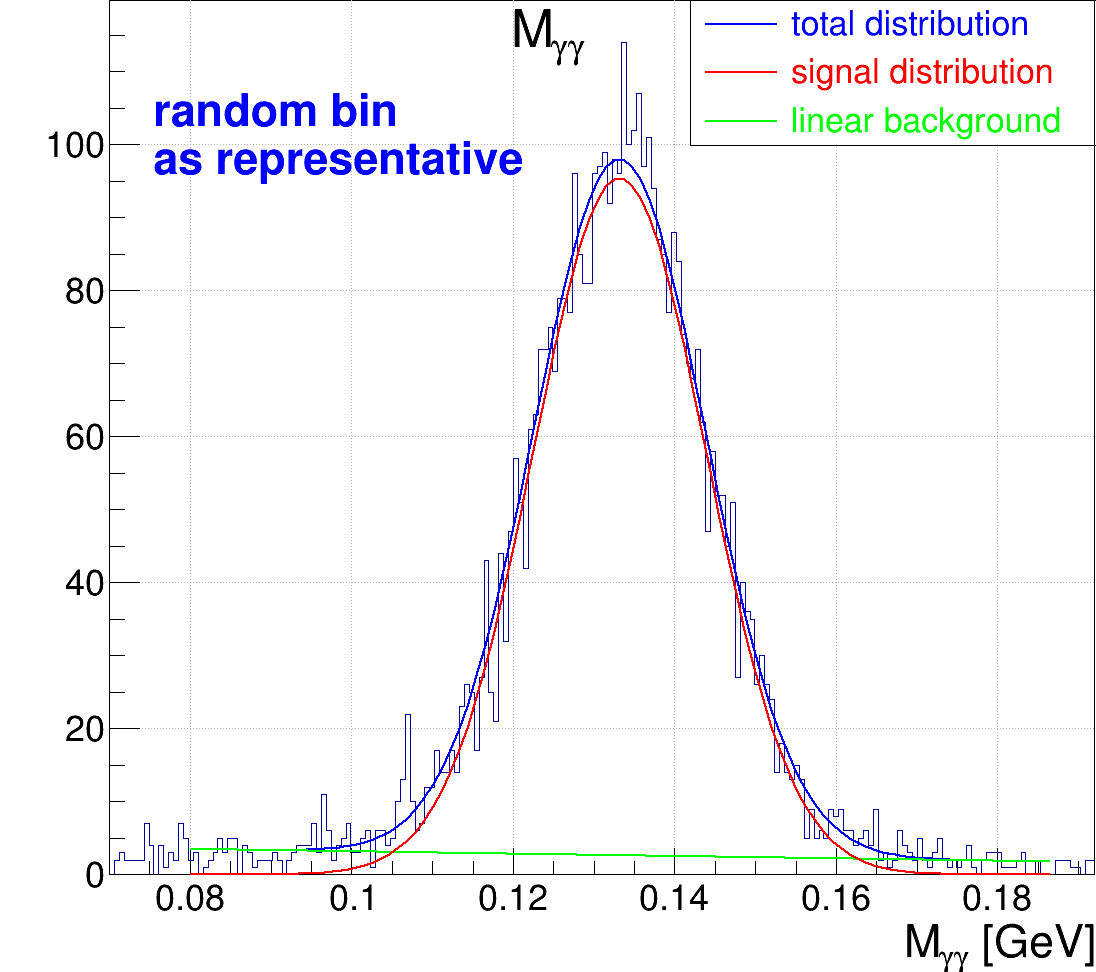

In [15]:
c1 = ROOT.TCanvas("c1","c1", 1100,1000)
c1.SetMargin(0.1,0.001,0.1,0.001)
c1.Draw()

hgg = df.Filter("iqx==2 && itt==2").Histo1D(("hgg","M_{#gamma#gamma};M_{#gamma#gamma} [GeV]",200,0.07,0.192),"mgg")
fgg = ROOT.TF1("fgg","gausn(0)+pol1(3)",0,1)
fgg.SetParameters(1,0.135,0.01,1,-1)
hgg.Fit(fgg,"QL")
mu,sig = fgg.GetParameter(1), fgg.GetParameter(2)
fgg.SetRange(mu-5*sig, mu+5*sig)
fgg.SetLineColor(4)
hgg.Fit(fgg,"QLR")
fbg = ROOT.TF1("fbg","pol1",fgg.GetXmin(), fgg.GetXmax())
fbg.SetParameters(fgg.GetParameter(3), fgg.GetParameter(4))
fbg.SetLineColor(3)
fsig = ROOT.TF1("fsig","gausn",fgg.GetXmin(), fgg.GetXmax())
fsig.SetParameters(fgg.GetParameter(0), fgg.GetParameter(1), fgg.GetParameter(2))
fsig.SetLineColor(2)
hgg.Draw()
fbg.Draw("same")
fsig.Draw("same")

leg = ROOT.TLegend(0.63,0.85,1,1)
leg.AddEntry(fgg,"total distribution", "L").SetTextColor(fgg.GetLineColor())
leg.AddEntry(fsig,"signal distribution", "L").SetTextColor(fsig.GetLineColor())
leg.AddEntry(fbg,"linear background", "L").SetTextColor(fbg.GetLineColor())
leg.Draw()

lat1 = lat.DrawLatexNDC(0.14,0.87,"random bin")
lat1.SetTextSize(0.05)
lat1.SetTextColor(4)
lat1.DrawLatexNDC(0.14,0.82,"as representative")

c1.Print("pdf/eppi0.mgg.bin.fit.example.pdf")